In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

In [155]:
# from ercollect import molecule as mol
# from ercollect.molecule import molecule
from ercollect.rxn_syst import reaction, get_RS, yield_rxn_syst
import matplotlib.pyplot as plt
import numpy as np
import sys
from rdkit.Chem import Fragments, Descriptors
# import random
# import os
# import requests
# from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
# from IPython.display import clear_output
# from ercollect import SABIO_IO

Author: Andrew Tarzia

Date Created: 11 Dec 2018

Distributed under the terms of the MIT License.

# Notebook to analyse reaction systems for the SALE-ZIF-8 case study

## Step 1:
- Find reaction systems with maximum component sizes within some range
    - lower threshold $\leq d \leq$ upper threshold

In [78]:
threshold = (6, 8)

In [79]:
directory = '/home/atarzia/psp/screening_results/'
directory += 'kegg_111218/'
# directory += 'new_reactions_atlas_111218/'
# directory += 'new_reactions_kegg_atlas/'
# directory += 'new_reactions_sabio_wcharge/'
# directory += 'biomin_search_sabio_wcharge/'

In [80]:
target_RS = []
out_range = []
in_range = []
for i, rs in enumerate(yield_rxn_syst(output_dir=directory)):
    if rs.skip_rxn is True:
        continue
    if rs.max_comp_size is None:
        continue
    if rs.max_comp_size >= threshold[0] and rs.max_comp_size <= threshold[1]:
        target_RS.append(rs.pkl)
        in_range.append(rs.max_comp_size)
    else:
        out_range.append(rs.max_comp_size)    

1931 reactions in threshold


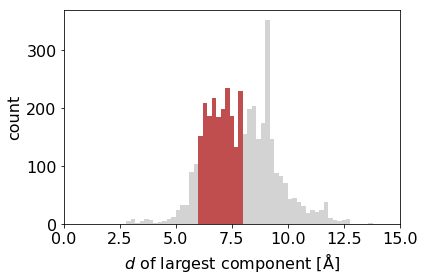

In [81]:
print(len(target_RS), 'reactions in threshold')
fig, ax = plt.subplots()
ax.hist(in_range, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(0, 20, 0.2))
ax.hist(out_range, 
        facecolor='lightgray',  # '#FF7900', 
        histtype='stepfilled', bins=np.arange(0, 20, 0.2))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('$d$ of largest component [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 15)
fig.tight_layout()
fig.savefig(directory+"CS_maxd.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 2:
- From the target RS:
    - Search for reactions that show a gain or loss of a UV/Vis or IR active component
    - searching for:
        - terminal acetylenes: rdkit.Chem.Fragments.fr_term_acetylene
        - nitriles: rdkit.Chem.Fragments.fr_nitrile

In [82]:
def has_terminal_acetylene(SMILES):
    """Returns False if terminal acetylene fragment is not found using RDKIT.

    """
    mol = Chem.MolFromSmiles(SMILES)
    no_frag = Fragments.fr_term_acetylene(mol)
    if no_frag > 0:
        return True
    else:
        return False
    

def has_nitrile(SMILES):
    """Returns False if terminal acetylene fragment is not found using RDKIT.

    """
    mol = Chem.MolFromSmiles(SMILES)
    no_frag = Fragments.fr_nitrile(mol)
    if no_frag > 0:
        return True
    else:
        return False

In [135]:
target_RS_2 = []
has_acet = 0
has_nit = 0
for pkl in target_RS:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    r_acet = 0
    r_nit = 0
    p_acet = 0
    p_nit = 0
    for m in rs.components:
        acet = has_terminal_acetylene(m.SMILES)
        nit = has_nitrile(m.SMILES)
        if m.role == 'reactant':
            if acet is True:
                r_acet += 1
            if nit is True:
                r_nit += 1
        elif m.role == 'product':
            if acet is True:
                p_acet += 1
            if nit is True:
                p_nit += 1
    if r_acet > 0 or p_acet > 0 or r_nit > 0 or p_nit >0:
        print('------------------------------------------------------')
        print(r_acet, p_acet, r_nit, p_nit)
        if p_acet == 0 and r_acet > 0:
            target_RS_2.append(rs.pkl)
            has_acet += 1
            print('1')
        elif r_acet == 0 and p_acet > 0:
            target_RS_2.append(rs.pkl)
            has_acet += 1
            print('2')
        elif p_nit == 0 and r_nit > 0:
            target_RS_2.append(rs.pkl)
            has_nit += 1
            print('3')
        elif r_nit == 0 and p_nit > 0:
            target_RS_2.append(rs.pkl)
            has_nit += 1
            print('4')
        print(rs.pkl)

------------------------------------------------------
0 0 0 1
4
sRS-1_14_14_37-KEGG-R04306.gpkl
------------------------------------------------------
0 0 0 1
4
sRS-1_14_14_44-KEGG-R07638.gpkl
------------------------------------------------------
0 0 1 1
sRS-1_1_3_49-KEGG-R11380.gpkl
------------------------------------------------------
0 0 1 1
sRS-2_3_2_2-KEGG-R03970.gpkl
------------------------------------------------------
0 0 1 1
sRS-2_3_2_2-KEGG-R03971.gpkl
------------------------------------------------------
0 0 1 0
3
sRS-3_5_5_1-KEGG-R01887.gpkl
------------------------------------------------------
0 0 1 0
3
sRS-3_5_5_1-KEGG-R03093.gpkl
------------------------------------------------------
0 0 1 0
3
sRS-3_5_5_1-KEGG-R05591.gpkl
------------------------------------------------------
0 0 1 0
3
sRS-3_5_5_1-KEGG-R07855.gpkl
------------------------------------------------------
0 0 1 0
3
sRS-3_5_5_4-KEGG-R00486.gpkl
------------------------------------------------------
0 0 

17 reactions in threshold


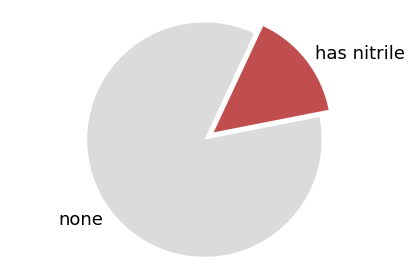

In [153]:
print(len(target_RS_2), 'reactions in threshold')
fig, ax = plt.subplots()    
# Data to plot
labels = 'none', 'has nitrile'
sizes = [len(target_RS), has_nit*20]
colors = ['lightgray', 'firebrick']
explode = (0, 0.1)  # explode 1st slice
 
# Plot
patches, texts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                        shadow=False, startangle=65)
for i in texts:
    i.set_fontsize(18)
for i in patches:
    i.set_alpha(0.8)
ax.axis('equal')
fig.tight_layout()
fig.savefig(directory+"CS_pie.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 3:
- Plot the maximum logP vs. maximum logS of the remaining reactions

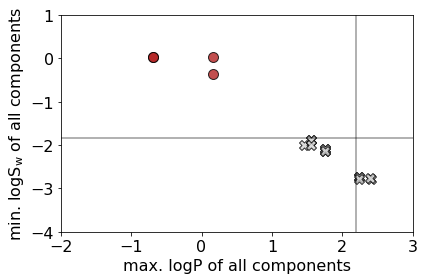

In [154]:
Y_cut = -1.84  # logS of pentane
X_cut = 2.1965  # logP of pentane
fig, ax = plt.subplots()
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    if rs.min_logS > Y_cut and rs.max_logP < X_cut:
        ax.scatter(rs.max_logP, rs.min_logS, c='firebrick', alpha=0.8, s=100, edgecolor='k')
    else:
        ax.scatter(rs.max_logP, rs.min_logS, c='lightgray', alpha=0.8, s=100, marker='X', edgecolor='k')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max. logP of all components', fontsize=16)
ax.set_ylabel('min. logS$_{\mathrm{w}}$ of all components', fontsize=16)
ax.axhline(y=Y_cut, c='k', alpha=0.4)
ax.axvline(x=X_cut, c='k', alpha=0.4)
ax.set_xlim(-2, 3)
ax.set_ylim(-4, 1)
fig.tight_layout()
fig.savefig(directory+"CS_solub.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()   

## Step 4:
- Print each reaction (only print reactions with fully specified EC numbers)

In [159]:
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    if '-' in rs.EC:
        continue
    if rs.min_logS < Y_cut or rs.max_logP > X_cut:
        continue
    print('---------------')
    print(rs.pkl)
    print('EC:', rs.EC, ' --- KEGG ID:', rs.DB_ID)
    print('min logS:', rs.min_logS, 'max logP:', rs.max_logP)
    before_str = []
    after_str = []
    for m in rs.components:
        if m.role == 'reactant':
            before_str.append(m.name)
        elif m.role == 'product':
            after_str.append(m.name)
        print(m.name, ':', Descriptors.ExactMolWt(Chem.MolFromSmiles(m.SMILES)))
    print(' + '.join(before_str), '<->', ' + '.join(after_str))
    print('---------------')

---------------
sRS-3_5_5_1-KEGG-R01887.gpkl
EC: 3.5.5.1  --- KEGG ID: R01887
min logS: -0.35491886800302413 max logP: 0.16199999999999998
C05715 : 128.058577496
C00001 : 18.010564684
C00302 : 147.053157768
C00014 : 17.026549096
C05715 + C00001 <-> C00302 + C00014
---------------
---------------
sRS-3_5_5_4-KEGG-R00486.gpkl
EC: 3.5.5.4  --- KEGG ID: R00486
min logS: 0.023729556962231432 max logP: 0.16199999999999998
C02512 : 114.042927432
C00001 : 18.010564684
C00049 : 133.037507704
C00014 : 17.026549096
C02512 + C00001 <-> C00049 + C00014
---------------
---------------
sRS-3_5_5_4-KEGG-R01267.gpkl
EC: 3.5.5.4  --- KEGG ID: R01267
min logS: 0.023729556962231432 max logP: -0.6880200000000001
C00152 : 132.053492116
C02512 : 114.042927432
C00001 : 18.010564684
C00152 <-> C02512 + C00001
---------------
---------------
sRS-4_2_1_65-KEGG-R01267.gpkl
EC: 4.2.1.65  --- KEGG ID: R01267
min logS: 0.023729556962231432 max logP: -0.6880200000000001
C00152 : 132.053492116
C02512 : 114.042927432
C

# Done

## Step 3 (UNUSED):
- Select reactions with only one reactant

In [49]:
target_RS_3 = []
no_react_1 = []
no_react_above = []
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    no_r = 0
    for m in rs.components:
        if m.role == 'reactant':
            no_r += 1
    if no_r > 1:
        no_react_above.append(no_r)
    elif no_r == 1:
        no_react_1.append(no_r)
        target_RS_3.append(rs.pkl)
    else:
        print('THERE IS A PROBLEM HERE!')
        print(rs.pkl)
        print(rs.DB_ID, rs.DB)
        sys.exit()


73 reactions in threshold


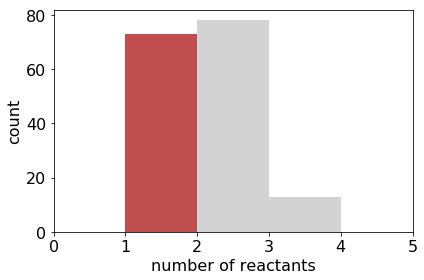

In [50]:
print(len(target_RS_3), 'reactions in threshold')
fig, ax = plt.subplots()    
ax.hist(no_react_1, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(0, 10, 1))
ax.hist(no_react_above,  
        facecolor='lightgray',  # '#FF7900',  
        histtype='stepfilled', bins=np.arange(0, 10, 1))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('number of reactants', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 5)
fig.tight_layout()
fig.savefig(directory+"CS_NoR.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 2 (unused):
- From the target RS:
    - Plot the value added as the change in synthetic accessibility
    - Select out reactions with a change in synthetic accessibility $>$ SA threshold

In [60]:
SA_threshold = 1.5

In [61]:
target_RS_2 = []
top_delta_SA = []
other_delta_SA = []
for pkl in target_RS:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    if abs(rs.delta_sa) > SA_threshold:
        top_delta_SA.append(rs.delta_sa)
        target_RS_2.append(rs.pkl)
    else:
        other_delta_SA.append(rs.delta_sa)

35 reactions in threshold


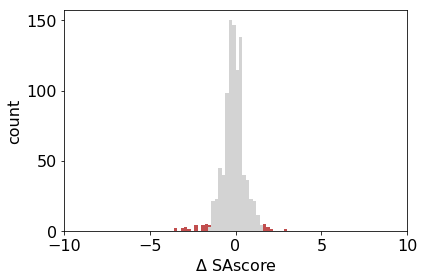

In [62]:
print(len(target_RS_2), 'reactions in threshold')
fig, ax = plt.subplots()    
ax.hist(top_delta_SA, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(-10, 10, 0.2))
ax.hist(other_delta_SA, 
        facecolor='lightgray',  # '#FF7900', 
        histtype='stepfilled', bins=np.arange(-10, 10, 0.2))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('$\Delta$ SAscore', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(-10, 10)
fig.tight_layout()
fig.savefig(directory+"CS_changeSA.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()